1/ Develop the algorithms for liver segmentation in MR images<br/>
b) Use the fast-marching algorithm only <br/>
c) Combine the fast-marching algorithm and level segmentation. <br/>

Fast-marching algorithm is applied on the smooth-image derived from the gaussian filter algorithm, which smooths the image and reduces noise of the image. The number of range of iteration must be chosen through some experiments, if not it will makes the "known" pixel leaked out from the object.
I used the algorithm described in this paper: http://essay.utwente.nl/75601/1/Alblas_BA_EWI.pdf

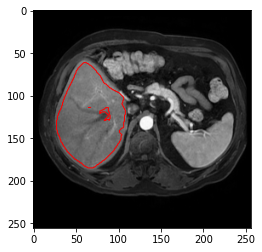

In [11]:
import heapq
import math
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.transform import resize
import itertools
from heapq import heappush, heappop
import sys
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Data structure for storing the neighbor pixel
class PriorityQueue:
    def __init__(self):
        self.pq = []                         # list of entries arranged in a heap
        self.entry_finder = {}               # mapping of tasks to entries
        self.REMOVED = '<removed-task>'      # placeholder for a removed task
        self.counter = itertools.count()     # unique sequence count
            
    def add(self,task, priority=0):
        'Add a new task or update the priority of an existing task'
        if task in self.entry_finder:
            if self.entry_finder[task][0] > priority:
                self.remove(task)
                count = next(self.counter)
                entry = [priority, count, task]
                self.entry_finder[task] = entry
                heappush(self.pq, entry)
            else:
                return
        if task not in self.entry_finder:
            count = next(self.counter)
            entry = [priority, count, task]
            self.entry_finder[task] = entry
            heappush(self.pq, entry)

    def remove(self,task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while pq:
            priority, count, task = heappop(self.pq)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task, priority
        raise KeyError('pop from an empty priority queue')
    def empty(self):
        return len(self.pq) == 0

def grad(x): 
    return np.array(np.gradient(x))


def norm(x, axis=0):
    return np.sqrt(np.sum(np.square(x), axis=axis))

# Speed function
def speed_func(x, alpha):
    return np.exp(1.-alpha * (norm(grad(x))**2))

# Initialize status at start point
def default_status(x,startY,startX):
    phi = np.ones(x.shape[:2])
    phi[:] = -1
    phi[startX,startY] = 1
    phi[startX+1,startY] = 0
    phi[startX-1,startY] = 0
    phi[startX,startY+1] = 0
    phi[startX,startY-1] = 0
    return phi
#(i,j) = 1 for known
#(i,j) = 0 for neighbor
#(i,j) = -1 for far
# Neighbor to known

# neighbor to known
def n2k(status,y,x):
    status[x,y] = 1
    
# Far to known
def f2n(status,y,x):
    if status[x+1,y] == -1.:
        status[x+1,y] = 0

    if status[x-1,y] == -1.: 
        status[x-1,y] = 0
        
    if status[x,y+1] == -1.:
        status[x,y+1] = 0

    if status[x,y-1] == -1.:
        status[x,y-1] = 0

# Set up time matrix
def default_T(x,startY,startX):
    T = np.ones(x.shape[:2])
    T[:]=np.inf
    T[startX,startY] = 0
    return T
# Calculate arrival time of the known pixel
def calc_t(t,j,i,F): 
    a = min(t[i-1,j],t[i+1,j])
    b = min(t[i,j-1],t[i,j+1])
    if (1/F[i,j]) > abs(a-b):
        temp = (a+b+math.sqrt(2*(1/F[i,j])**2 - (a-b)**2))/2
    else:
        temp = (1/F[i,j])**2 + min(a,b)
    return temp
# Put time into matrix
def addtime(t, value, x, y):
    t[y,x] = value

img = io.imread('D:/studies/word_image_generator-master/Liver_MRI0001/phase1/img0059.dcm')
img_smooth = scipy.ndimage.filters.gaussian_filter(img, 4)
# img_smooth = scipy.ndimage.median_filter(img,20)
F = speed_func(img_smooth, 1)
# set initial seed
startX = 60
startY = 120
# loop time
n = 6500
status = default_status(img_smooth,startX,startY)
t = default_T(img_smooth,startX,startY)

pq = PriorityQueue()

# Set up initial queue
temp = calc_t(t,startX+1,startY,F)
pq.add((startX+1,startY),temp)

temp = calc_t(t,startX,startY+1,F)
pq.add((startX,startY+1),temp)

temp = calc_t(t,startX,startY-1,F)
pq.add((startX,startY-1),temp)

temp = calc_t(t,startX-1,startY,F)
pq.add((startX-1,startY),temp)

# Perform fast marching algorithm from startX, startY
# calculate all time of neighbors 
# add to queue that smaller time means higher priority
# pop out the first value in queue
# update matrix n2k and f2n
# add new neighbor after having new known
for i in range(n):
    obj = pq.pop()
    x,y = obj[0]
    time = obj[1]
    addtime(t,time,x,y)
    n2k(status,x,y)
    f2n(status,x,y)
    if(0 < x < status.shape[0] and 0 < y < status.shape[1]):
        if status[y,x-1] == 0:
            temp = calc_t(t, x-1, y, F)
            pq.add((x-1, y), temp)

        if status[y,x+1] == 0:
            temp = calc_t(t,x+1, y, F)
            pq.add((x+1, y), temp)

        if status[y+1,x] == 0:
            temp = calc_t(t, x, y+1, F) 
            pq.add((x,y+1), temp)

        if status[y-1,x] == 0:
            temp = calc_t(t, x, y-1, F)
            pq.add((x, y-1), temp)

plt.imshow(img, cmap='Greys_r')
plt.contour(status, 0, colors='r', linewidths=[1])
plt.draw()
plt.show()
# interact(run_fast_marching, n=(0,7000,100),startX=fixed(60),startY=fixed(120))

Level-set method take the result form fast-marching method and improving the result. For applying the level set method, we used existing status matrix from fast marching method as initial phi in level set method. Then continue to apply level set by using Geodesic Active Contour (GAC) formulation. The first term is the smoothing term, it moves the curve into the direction of its curvature. The second term is the balloon term, controlling the speed of the curve propagation with parameter v. Lastly, the third term is the image attachment term that helps the curve to converge. <br/>

I used this as mine reference for level set: https://wiseodd.github.io/techblog/2016/11/20/levelset-segmentation/

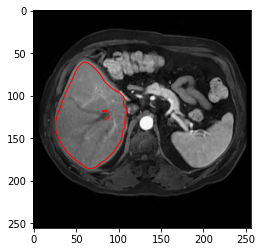

In [12]:
def stopping_fun(x):
    return 1. / (1. + norm(grad(x))**2)
def curvature(f):
    fy, fx = grad(f)
    norm = np.sqrt(fx**2 + fy**2)
    Nx = fx / (norm + 1e-8)
    Ny = fy / (norm + 1e-8)
    return div(Nx, Ny)


def div(fx, fy):
    fyy, fyx = grad(fy)
    fxy, fxx = grad(fx)
    return fxx + fyy


def dot(x, y, axis=0):
    return np.sum(x * y, axis=axis)


F = stopping_fun(img_smooth)
dg = grad(F)
dt = 1
v = 1
for i in range(1500):
    dphi = grad(status)
    dphi_norm = norm(dphi)
    kappa = curvature(status)

    smoothing = F * kappa * dphi_norm
    balloon = F * dphi_norm * v
    attachment = dot(dphi, dg)

    dphi_t = smoothing + balloon + attachment

    status = status + dt * dphi_t
plt.imshow(img, cmap='Greys_r')
plt.contour(status, 0, colors='r', linewidths=[1])
plt.draw()
plt.show()

After applying the level-set, the contour will try to expand until it get closer to the boundary of the liver. However, if the number of iteration for the level set is too big, it will makes the contour leaked out from the object.